In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

In [2]:
# define VRP

customer_count = 12
vehicle_capacity = 3


# the number of vehicle
vehicle_count = 20


#create dataframe
df = pd.DataFrame({
    'x': np.random.randint(0, 100, customer_count),
    'y': np.random.randint(0, 100, customer_count),
    'demand': np.random.randint(1, 4, customer_count),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0
df.iloc[-1]['x'] = 50
df.iloc[-1]['y'] = 50
df.iloc[-1]['demand'] = 0

df


,x,y,demand
0,0,0,0
1,42,32,3
2,0,40,2
3,16,98,3
4,21,74,2
5,8,16,1
6,22,93,2
7,2,82,2
8,82,6,3
9,24,28,2


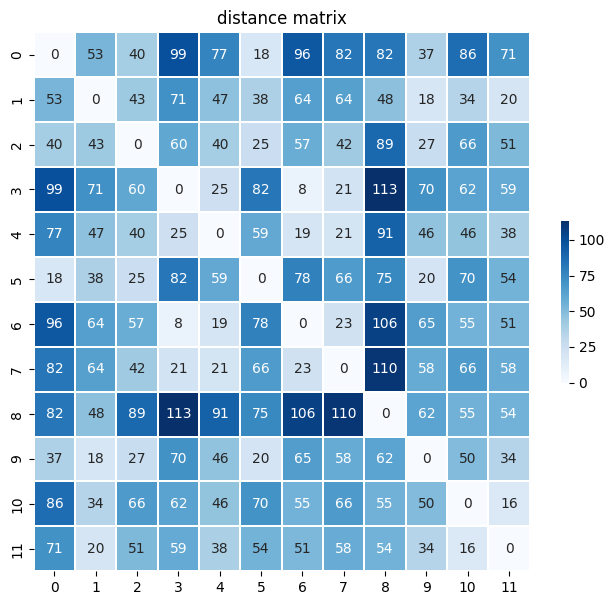

In [3]:
# get distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

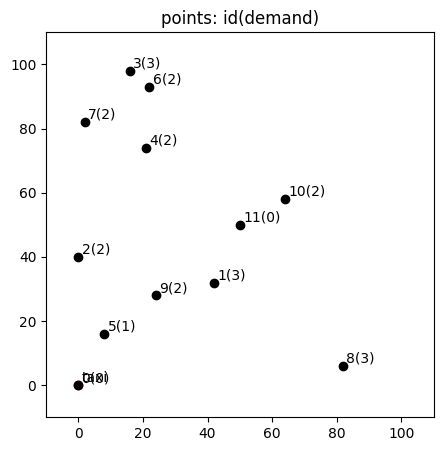

In [4]:
# check VRP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='red')
        plt.text(row['x'] + 1, row['y'] + 1, 'taxi')
    if i == -1:
        plt.scatter(row['x'], row['y'], c='green')
        plt.text(row['x'] + 1, row['y'] + 1, 'hotspot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

In [5]:
# solve with pulp

demands = df['demand'].values

for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    # already includes constraint sum(xii) = 0
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
    u = pulp.LpVariable.dicts('u', (i for i in range(1, customer_count)), lowBound=0, cat='Continuous')

    # add objective function
    problem += pulp.lpSum(distances[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

#CONSTRAINTS

    # pickup all points with exactly one cab
    for j in range(1,customer_count-1):
        problem += pulp.lpSum(x[i][j][k] for i in range(customer_count) for k in range(vehicle_count)) == 1


    #depart from Taxi
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 0

    #arrive at Hotspot
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[i][customer_count-1][k] for i in range(customer_count-1)) == 1
        problem += pulp.lpSum(x[customer_count-1][j][k] for j in range(customer_count-1)) == 0

    # demand collected on the route is less than Vehicle Capacity
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j]*x[i][j][k] if i != j else 0
                              for i in range(customer_count) for j in range(customer_count)) <= vehicle_capacity

    #if arrive then leave
    for k in range(vehicle_count):
        for j in range(1,customer_count-1):
            problem += pulp.lpSum( pulp.lpSum(x[i][j][k] for i in range(0,customer_count-1)) ) == ( pulp.lpSum(x[j][m][k] for m in range(1,customer_count)) )

    # Subtour Elimination (MTZ constraints)
    for i in range(1, customer_count):
        problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
        problem += u[i] <= customer_count - 1  # Sets an upper bound for u[i]
    for k in range(vehicle_count):
        for i in range(1, customer_count):
            for j in range(1, customer_count):
                if i != j:
                    problem += u[i] - u[j] + (customer_count - 1) * x[i][j][k] <= customer_count- 2

    # solve problem
    status = problem.solve()
    print(status)

    if status == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5a510ef531e3411899ada59e1ef21a64-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/5a510ef531e3411899ada59e1ef21a64-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 162 COLUMNS
At line 1375 RHS
At line 1533 BOUNDS
At line 1666 ENDATA
Problem MODEL has 157 rows, 143 columns and 816 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

-1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/16647705ca5e4320a65514a144519021-pulp.mps -timeMode e

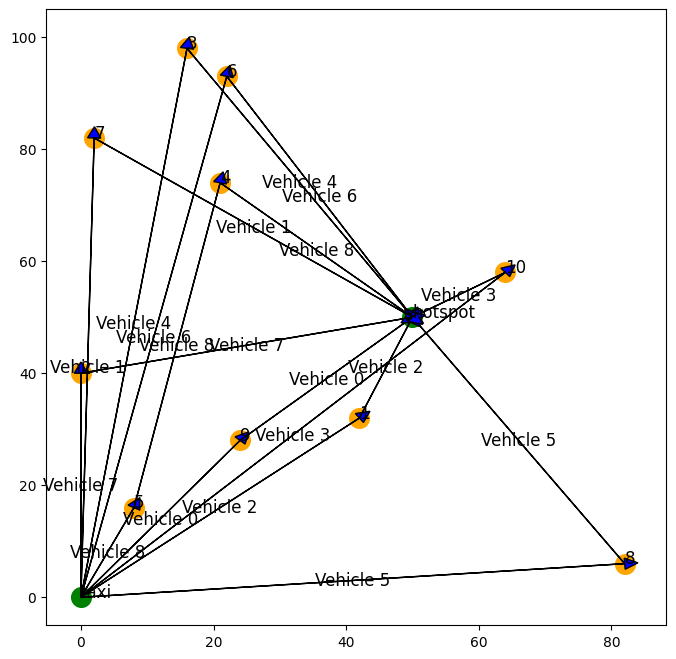

In [6]:
# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):
    if i == 0:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='green', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "taxi", fontsize=12)
    elif i == customer_count -1:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='green', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "hotspot", fontsize=12)
    else:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='orange', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], str(i), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.arrow(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[j]['x']-df.iloc[i]['x'], df.iloc[j]['y']-df.iloc[i]['y'], head_width=2, head_length=2, fc='blue', ec='black')

                mid_x = (df.iloc[i]['x'] + df.iloc[j]['x']) / 2
                mid_y = (df.iloc[i]['y'] + df.iloc[j]['y']) / 2
                plt.text(mid_x, mid_y, f"Vehicle {k}", ha="center", va="center", fontsize=12)



plt.show()


In [7]:
for k in range(vehicle_count):
  sum = 0
  for i in range(customer_count):
      for j in range(customer_count):
          if i != j and pulp.value(x[i][j][k]) == 1:
            sum+= pulp.value(distances[i][j] * x[i][j][k])
  print(k, sum)

0 70.93695056102436
1 139.71320702506333
2 72.49923073336855
3 102.49580702335383
4 158.11929737786224
5 136.62510119931963
6 146.87949705536806
7 90.99019513592785
8 114.97064867629007


In [8]:
for k in range(vehicle_count):
  CP = 0
  SP = 0
  cab_cap = 0
  for i in range(customer_count-1):
      for j in range(1, customer_count):
          if i != j and pulp.value(x[i][j][k]) == 1:

            dist = pulp.value(distances[i][j] * x[i][j][k])
            CP+= dist
            if i==0:
              continue
            else:
              cab_cap += demands[i]
              SP += dist*cab_cap
            i = j
            break

  print(k, CP, SP, SP-CP)

0 70.93695056102436 68.11754546370561 -2.81940509731875
1 139.71320702506333 115.37764081484765 -24.335566210215674
2 72.49923073336855 59.093146810776624 -13.406083922591925
3 102.49580702335383 32.2490309931942 -70.24677603015964
4 158.11929737786224 176.4652940382329 18.345996660370673
5 136.62510119931963 163.21764610482532 26.59254490550569
6 146.87949705536806 102.62553288534 -44.25396417002807
7 90.99019513592785 101.9803902718557 10.990195135927848
8 114.97064867629007 253.6032541194378 138.63260544314772
